In [1]:
import os
import pandas as pd
from azure.identity.aio import ManagedIdentityCredential
cred = ManagedIdentityCredential()
opts = {'account_name': 'datalakestorage7nrw9r', 'credential': cred, 'anon': False}
folder_path = "abfs://datalakegen2filesystem/analytics/connectedcar/chenha01/Churn/"

train = pd.read_csv(folder_path + 'trainOneMonth_stratify.csv', delimiter=',', storage_options=opts)
test = pd.read_csv(folder_path + 'testOneMonth_stratify.csv', delimiter=',', storage_options=opts)
valid = pd.read_csv(folder_path + 'validOneMonth_stratify.csv', delimiter=',', storage_options=opts)

In [2]:
from sklearn import linear_model

In [3]:
OneMonthbins = pd.read_csv(folder_path + 'OneMonthbinsMixOldNew.csv', delimiter=',', storage_options=opts)
# convert OneMonthbins into dictionary, with variable as key, the vraiable's dataframe as value
columns = OneMonthbins['variable'].unique()
OneMonthbins_dict = {}
for col in columns:
    OneMonthbins_dict[col] = OneMonthbins[OneMonthbins['variable'] == col]
# apply OneMonthbins
import scorecardpy as sc
train_woe = sc.woebin_ply(train, OneMonthbins_dict)
train_woe['OneMonth_target'] = train['OneMonth_target']
valid_woe = sc.woebin_ply(valid, OneMonthbins_dict)
valid_woe['OneMonth_target'] = valid['OneMonth_target']
test_woe = sc.woebin_ply(test, OneMonthbins_dict)
test_woe['OneMonth_target'] = test['OneMonth_target']

[INFO] converting into woe values ...
Woe transformating on 60880 rows and 1641 columns in 00:03:48
[INFO] converting into woe values ...
Woe transformating on 26092 rows and 1641 columns in 00:01:34
[INFO] converting into woe values ...
Woe transformating on 15846 rows and 1641 columns in 00:00:58


In [8]:
# Read the GarageAttributes file
import os
with open(os.getcwd() + '/GarageAttributes', 'r') as file:
    garage_attributes = file.read().splitlines()
# Print the list of garage attribute names
print(garage_attributes)

['countallvehicles', 'countallvehiclesaddedpast1mth', 'countallvehiclesaddedpast2mths', 'countallvehiclesaddedpast3mths', 'countallvehiclesaddedpast6mths', 'countallvehiclesaddedpast12mths', 'countallvehiclesaddedpast24mths', 'countallvehiclesaddedpast36mths', 'countallvehiclesaddedpast48mths', 'countallvehiclesaddedpast60mths', 'countallvehiclespurchasednew', 'countallvehiclespurchasednewaddedpast1mth', 'countallvehiclespurchasednewaddedpast2mths', 'countallvehiclespurchasednewaddedpast3mths', 'countallvehiclespurchasednewaddedpast6mths', 'countallvehiclespurchasednewaddedpast12mths', 'countallvehiclespurchasednewaddedpast24mths', 'countallvehiclespurchasednewaddedpast36mths', 'countallvehiclespurchasednewaddedpast48mths', 'countallvehiclespurchasednewaddedpast60mths', 'countallvehiclespurchasedused', 'countallvehiclespurchasedusedaddedpast1mth', 'countallvehiclespurchasedusedaddedpast2mths', 'countallvehiclespurchasedusedaddedpast3mths', 'countallvehiclespurchasedusedaddedpast6mths',

In [5]:
# get value of woe when variable is 'statecode' and bin is missing
colum = 'statecode'
missing_woe = OneMonthbins[OneMonthbins['variable'] == colum]['woe'].iloc[0]
# fill missing values in 'statecode' with missing_woe
colum = colum + '_woe'
train_woe[colum] = train_woe[colum].fillna(missing_woe)
valid_woe[colum] = valid_woe[colum].fillna(missing_woe)
test_woe[colum] = test_woe[colum].fillna(missing_woe)

In [49]:
# Train
base_features = ["statecode_woe", "months_paying_woe", "combined_age_woe", "base_price_woe", "appfeatures_woe"]

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['statecode_woe', 'months_paying_woe', 'combined_age_woe', 'base_price_woe', 'appfeatures_woe']
train lift: 3.1600383357686894
test lift: 3.206415124929071


In [48]:
base_features = ["statecode_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe"]
dict = {}
best_rate = 0
best_col = ''
for col in base_features:
    base_features.remove(col)
    model = linear_model.LogisticRegression()
    model.fit(train_woe[base_features], train_woe['OneMonth_target'])
    # return probability of each row in test
    prob = model.predict_proba(valid_woe[base_features])
    # return probability of 1
    prob = [p[1] for p in prob]
    # sort prob in order
    valid_woe['prob'] = prob
    valid_woe.sort_values(by='prob', ascending=True, inplace=True)
    # group rows into 10 groups with same number of rows
    valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
    valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

    # group by group, calculate the sum of OneMonth_target and count of OneMonth_target
    test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
    # calculate rate of OneMonth_target by OneMonth_target /  pred
    test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
    # get rate of OneMonth_target from group as 0
    rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
    rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
    rate_9 / rate_0
    print(col, rate_9 / rate_0)
    dict[col] = rate_9 / rate_0
    if rate_9 / rate_0 > best_rate:
        best_rate = rate_9 / rate_0
        best_col = col
    # add the column back to first position
    base_features.insert(0, col)

statecode_woe 3.1101618006755447
months_paying_woe 2.1210627225417693
age_drv_woe 2.5832365276909846
base_price_woe 3.056742455560149
appfeatures_woe 2.9494505494505496


In [50]:
# loop over garage_attributes, add each to base_features, train model
# save col and rate_9 / rate_0 in a dict
dict = {}
best_rate = 0
best_col = ''
base_features = ["statecode_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe"]
for col in garage_attributes:
    col = col + '_woe'
    base_features.append(col)
    model = linear_model.LogisticRegression()
    try:
        model.fit(train_woe[base_features], train_woe['OneMonth_target'])
        # return probability of each row in test
        prob = model.predict_proba(train_woe[base_features])
        # return probability of 1
        prob = [p[1] for p in prob]
        # sort prob in order
        train_woe['prob'] = prob
        train_woe.sort_values(by='prob', ascending=True, inplace=True)
        # group rows into 10 groups with same number of rows
        train_woe['group'] = pd.qcut(train_woe['prob'], 10, labels=False)
        train_woe['OneMonth_target_Cnt'] = train_woe['OneMonth_target']

        # group by group, calculate the sum of OneMonth_target and count of OneMonth_target
        test_group = train_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
        # calculate rate of OneMonth_target by OneMonth_target /  pred
        test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
        # get rate of OneMonth_target from group as 0
        rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
        rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
        rate_9 / rate_0
        print(col, rate_9 / rate_0)
        # remove the column
        base_features.remove(col)
        dict[col] = rate_9 / rate_0
        if rate_9 / rate_0 > best_rate:
            best_rate = rate_9 / rate_0
            best_col = col
    except:
        base_features.remove(col)

countallvehicles_woe 3.2802782047917214
countallvehiclesaddedpast1mth_woe 3.2645520816667313
countallvehiclesaddedpast2mths_woe 3.320203269940356
countallvehiclesaddedpast3mths_woe 3.256688919611445
countallvehiclesaddedpast6mths_woe 3.2749072765807137
countallvehiclesaddedpast12mths_woe 3.3188262694057205
countallvehiclesaddedpast24mths_woe 3.36571425880145
countallvehiclesaddedpast36mths_woe 3.3206666702159944
countallvehiclesaddedpast48mths_woe 3.326975657366709
countallvehiclesaddedpast60mths_woe 3.320418858014961
countallvehiclespurchasednew_woe 3.1829349348318474
countallvehiclespurchasednewaddedpast1mth_woe 3.2235487393577444
countallvehiclespurchasednewaddedpast2mths_woe 3.199601329745935
countallvehiclespurchasednewaddedpast3mths_woe 3.2222579247918253
countallvehiclespurchasednewaddedpast6mths_woe 3.211253588724093
countallvehiclespurchasednewaddedpast12mths_woe 3.202222722835473
countallvehiclespurchasednewaddedpast24mths_woe 3.198734693346404
countallvehiclespurchasednewadd

In [51]:
# sort dict by value
dict = dict.items()
dict = sorted(dict, key=lambda x: x[1], reverse=True)
dict

[('countallvehiclespurchasedusedchevrolet_woe', 3.38913452208144),
 ('countallvehiclesaddedpast24mths_woe', 3.36571425880145),
 ('countallvehiclespurchasedusednonluxaddedpast60mths_woe', 3.360214170513221),
 ('countdisposedvehiclespurchasedused_woe', 3.3538210478180175),
 ('countallvehiclespurchasedused_woe', 3.3472712022974163),
 ('countallvehiclespurchasedusednonlux_woe', 3.34662672746516),
 ('countactivevehiclespurchasednewamerican_woe', 3.3427723362303343),
 ('countactivevehiclespurchasednewsameregion_woe', 3.3427723362303343),
 ('countallvehiclespurchasedusednonluxaddedpast3mths_woe', 3.3420980553273076),
 ('countallvehiclespurchasedusedaddedpast60mths_woe', 3.3414490803050696),
 ('countallvehiclespurchasedusedsedanaddedpast48mths_woe', 3.3411747579983158),
 ('countallvehiclespurchasedusedamerican_woe', 3.3408539281415846),
 ('countactivevehiclespurchasedusedaddedpast24mths_woe', 3.33647182232511),
 ('countactivevehiclespurchasedusedamerican_woe', 3.333333333333333),
 ('avgmonthst

In [57]:
# Train
base_features = ["statecode_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesaddedpast24mths_woe']

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(train_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
train_woe['prob'] = prob
train_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
train_woe['group'] = pd.qcut(train_woe['prob'], 10, labels=False)
train_woe['OneMonth_target_Cnt'] = train_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
train_group = train_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
train_group['rate'] = train_group['OneMonth_target'] / train_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = train_group[train_group['group'] == 0]['rate'].values[0]
rate_9_ = train_group[train_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['statecode_woe', 'months_paying_woe', 'age_drv_woe', 'base_price_woe', 'appfeatures_woe', 'countallvehiclesaddedpast24mths_woe']
train lift: 3.36571425880145
test lift: 3.4913747346072186


In [58]:
# remove columns in garage_attributes_keep from columns_keep
columns_keep = [i for i in train_woe.columns if i + 'woe' not in garage_attributes]
# remove OneMonth_target from columns_keep
columns_keep.remove('OneMonth_target')

In [60]:
# loop over garage_attributes, add each to base_features, train model
# save col and rate_9 / rate_0 in a dict
dict_ = {}
best_rate = 0
best_col = ''
base_features = ["statecode_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesaddedpast24mths_woe']
for col in columns_keep:
    base_features.append(col)
    model = linear_model.LogisticRegression()
    model.fit(train_woe[base_features], train_woe['OneMonth_target'])
    # return probability of each row in test
    prob = model.predict_proba(train_woe[base_features])
    # return probability of 1
    prob = [p[1] for p in prob]
    # sort prob in order
    train_woe['prob'] = prob
    train_woe.sort_values(by='prob', ascending=True, inplace=True)
    # group rows into 10 groups with same number of rows
    train_woe['group'] = pd.qcut(train_woe['prob'], 10, labels=False)
    train_woe['OneMonth_target_Cnt'] = train_woe['OneMonth_target']

    # group by group, calculate the sum of OneMonth_target and count of OneMonth_target
    test_group = train_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
    # calculate rate of OneMonth_target by OneMonth_target /  pred
    test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
    # get rate of OneMonth_target from group as 0
    rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
    rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
    rate_9 / rate_0
    print(col, rate_9 / rate_0)
    # remove the column
    base_features.remove(col)
    dict_[col] = rate_9 / rate_0
    if rate_9 / rate_0 > best_rate:
        best_rate = rate_9 / rate_0
        best_col = col

countdisposedvehiclesremovedpast48mth_woe 3.3539765367265497
number_of_adults_in_household_woe 3.2562907352500976
countactivevehiclespurchasednewlotus_woe 3.3556054755074385
summonthstenureactiveveholdestactive_woe 3.294310256218776
countdisposedvehiclespurchasedusedhyundaigroup_woe 3.3556054755074385
alternate_lot_woe 3.3519780067777853
countallvehiclesgasaddedpast60mths_woe 3.3537021212560933
countdisposedvehiclespurchasednewtoyotagroup_woe 3.3556054755074385
avgmonthstenureallvehcderived_woe 3.3352498925583145
countallvehiclespurchasedusedsuvaddedpast3mths_woe 3.318657617696553
countactivevehiclescadillac_woe 3.3657546238814744
v1_resinputavmvalue12mo_woe 3.363474316220407
premiummodelbase_woe 3.340579163263132
countallvehiclesmini_woe 3.3556054755074385
countdisposedvehiclespurchasedusednissan_woe 3.3620218579234975
countactivevehiclespurchasedusedporsche_woe 3.3556054755074385
countallvehiclespurchasednewamerican_woe 3.3536380205146186
pctactivevehiclesramderived_woe 3.35560547550

/tmp/ipykernel_160261/1435291501.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  rate_9 / rate_0
/tmp/ipykernel_160261/1435291501.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  print(col, rate_9 / rate_0)
/tmp/ipykernel_160261/1435291501.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  dict_[col] = rate_9 / rate_0
/tmp/ipykernel_160261/1435291501.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  if rate_9 / rate_0 > best_rate:
/tmp/ipykernel_160261/1435291501.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  best_rate = rate_9 / rate_0


In [62]:
# sort dict by value
dict = dict_.items()
dict = sorted(dict, key=lambda x: x[1], reverse=True)
dict

[('OneMonth_target_Cnt', inf),
 ('churn_fin_mth_error_woe', 12.731421566835177),
 ('TwoMonth_target_woe', 9.409505503538053),
 ('bodilyinjurylimitsxb_woe', 3.4048814816086233),
 ('countactivevehiclespurchasednewsamemake_woe', 3.402146092987192),
 ('hisp_score_drv_woe', 3.40015962298571),
 ('summonthstenureallvehiclesotherregion_woe', 3.3999667574605406),
 ('inq_count24_woe', 3.3983949975074235),
 ('prevaddractivephonelist_woe', 3.396223213639325),
 ('alternate_lot_order_woe', 3.3959827106853817),
 ('premium_score_woe', 3.394520547945205),
 ('v1_hhppcurrownedautocnt_woe', 3.3928754580735405),
 ('annuity_model_woe', 3.392567633263261),
 ('countactivevehiclespurchasednewchevrolet_woe', 3.391236145336909),
 ('v1_hhppcurrownedcnt_woe', 3.3908306689774887),
 ('veh_make_woe', 3.389841104924957),
 ('slpi_drv_woe', 3.389465246067986),
 ('v1_rescurravmtractratio_woe', 3.388784134070167),
 ('v1_raacollegegradattendedmmbrcnt_woe', 3.3878217623212183),
 ('countactivevehiclespurchasedusedgmgroup_woe

In [65]:
# Train
base_features = ["statecode_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesaddedpast24mths_woe', 'bodilyinjurylimitsxb_woe']

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['statecode_woe', 'months_paying_woe', 'age_drv_woe', 'base_price_woe', 'appfeatures_woe', 'countallvehiclesaddedpast24mths_woe', 'bodilyinjurylimitsxb_woe']
train lift: 3.2418781372002226
test lift: 3.534629747058409


In [68]:
import numpy as np
from scipy import stats
import pandas as pd

# p value
# remove rows wuth missing values
valid_woe.dropna(inplace=True)
params = np.append(model.intercept_, model.coef_)
predictions = model.predict(valid_woe[base_features])
newX = np.append(np.ones((len(valid_woe), 1)), valid_woe[base_features], axis=1)
MSE = (sum((valid_woe['OneMonth_target'] - predictions) ** 2)) / (len(newX) - len(newX[0]))

# Compute the dot product
matrix = np.dot(newX.T, newX)

# Check if the matrix is singular
if np.linalg.det(matrix) != 0:
    inv_matrix = np.linalg.inv(matrix)
else:
    inv_matrix = np.linalg.pinv(matrix)

var_b = MSE * inv_matrix.diagonal()
sd_b = np.sqrt(var_b)
ts_b = params / sd_b
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

# summary
summary = pd.DataFrame()
summary["features"] = ['intercept'] + base_features
summary["coefficients"] = params
summary["p_values"] = p_values
summary

,features,coefficients,p_values
0,intercept,-0.984552,0.0
1,statecode_woe,0.887690,0.0
2,months_paying_woe,0.872294,0.0
3,age_drv_woe,0.765691,0.0
4,base_price_woe,0.644534,0.0
5,appfeatures_woe,1.436792,0.0
6,countallvehiclesaddedpast24mths_woe,0.470876,0.0
7,bodilyinjurylimitsxb_woe,0.362801,0.0


In [69]:
# 2024 dataset only. All 3 files are from 2024
train_2024 = pd.read_csv(folder_path + 'beforewoe_train_stratify.csv', delimiter=',', storage_options=opts)
valid_2024 = pd.read_csv(folder_path + 'beforewoe_valid_stratify.csv', delimiter=',', storage_options=opts)
test_2024 = pd.read_csv(folder_path + 'beforewoe_test_stratify.csv', delimiter=',', storage_options=opts)

In [70]:
OneMonthbins = pd.read_csv(folder_path + 'OneMonthbins.csv', delimiter=',', storage_options=opts)
# convert OneMonthbins into dictionary, with variable as key, the vraiable's dataframe as value
columns = OneMonthbins['variable'].unique()
OneMonthbins_dict = {}
for col in columns:
    OneMonthbins_dict[col] = OneMonthbins[OneMonthbins['variable'] == col]
# apply OneMonthbins
import scorecardpy as sc
train_woe_2024 = sc.woebin_ply(train_2024, OneMonthbins_dict)
train_woe_2024['OneMonth_target'] = train_2024['OneMonth_target']
valid_woe_2024 = sc.woebin_ply(valid_2024, OneMonthbins_dict)
valid_woe_2024['OneMonth_target'] = valid_2024['OneMonth_target']
test_woe_2024 = sc.woebin_ply(test_2024, OneMonthbins_dict)
test_woe_2024['OneMonth_target'] = test_2024['OneMonth_target']

[INFO] converting into woe values ...
Woe transformating on 25880 rows and 1657 columns in 00:01:36
[INFO] converting into woe values ...
Woe transformating on 11092 rows and 1657 columns in 00:00:40
[INFO] converting into woe values ...
Woe transformating on 15846 rows and 1657 columns in 00:01:02


In [71]:
# get value of woe when variable is 'statecode' and bin is missing
colum = 'statecode'
missing_woe = OneMonthbins[OneMonthbins['variable'] == colum]['woe'].iloc[0]
# fill missing values in 'statecode' with missing_woe
colum = colum + '_woe'
train_woe_2024[colum] = train_woe_2024[colum].fillna(missing_woe)
valid_woe_2024[colum] = valid_woe_2024[colum].fillna(missing_woe)
test_woe_2024[colum] = test_woe_2024[colum].fillna(missing_woe)

In [73]:
model = linear_model.LogisticRegression()
model.fit(train_woe_2024[base_features], train_woe_2024['OneMonth_target'])

LogisticRegression()

In [74]:
import numpy as np
from scipy import stats
import pandas as pd

# p value
# remove rows wuth missing values
valid_woe_2024.dropna(inplace=True)
params = np.append(model.intercept_, model.coef_)
predictions = model.predict(valid_woe_2024[base_features])
newX = np.append(np.ones((len(valid_woe_2024), 1)), valid_woe_2024[base_features], axis=1)
MSE = (sum((valid_woe_2024['OneMonth_target'] - predictions) ** 2)) / (len(newX) - len(newX[0]))

# Compute the dot product
matrix = np.dot(newX.T, newX)

# Check if the matrix is singular
if np.linalg.det(matrix) != 0:
    inv_matrix = np.linalg.inv(matrix)
else:
    inv_matrix = np.linalg.pinv(matrix)

var_b = MSE * inv_matrix.diagonal()
sd_b = np.sqrt(var_b)
ts_b = params / sd_b
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

# summary
summary = pd.DataFrame()
summary["features"] = ['intercept'] + base_features
summary["coefficients"] = params
summary["p_values"] = p_values
summary

,features,coefficients,p_values
0,intercept,-0.970542,0.000000
1,statecode_woe,0.926250,0.000000
2,months_paying_woe,0.897173,0.000000
3,age_drv_woe,0.729455,0.000000
4,base_price_woe,0.607354,0.000000
5,appfeatures_woe,1.502429,0.000000
6,countallvehiclesaddedpast24mths_woe,0.538146,0.000000
7,bodilyinjurylimitsxb_woe,0.264290,0.000132


In [67]:
# Train
base_features = ["statecode_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesaddedpast24mths_woe', 'bodilyinjurylimitsxb_woe']

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['statecode_woe', 'months_paying_woe', 'age_drv_woe', 'base_price_woe', 'appfeatures_woe', 'countallvehiclesaddedpast24mths_woe', 'bodilyinjurylimitsxb_woe']
train lift: 3.2418781372002226
test lift: 3.534629747058409


In [11]:
# Final Model Train
base_features = ["state_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']

model = linear_model.LogisticRegression()
model.fit(train_woe[base_features], train_woe['OneMonth_target'])
# return probability of each row in test
prob = model.predict_proba(valid_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
valid_woe['prob'] = prob
valid_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0_ = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9_ = test_group[test_group['group'] == 9]['rate'].values[0]

# return probability of each row in test
prob = model.predict_proba(test_woe[base_features])
# return probability of 1
prob = [p[1] for p in prob]
# sort prob in order
test_woe['prob'] = prob
test_woe.sort_values(by='prob', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test_woe['group'] = pd.qcut(test_woe['prob'], 10, labels=False)
test_woe['OneMonth_target_Cnt'] = test_woe['OneMonth_target']

# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]

print(base_features)
print('train lift:', rate_9_ / rate_0_) 
print('test lift:', rate_9 / rate_0) 

['state_woe', 'months_paying_woe', 'age_drv_woe', 'base_price_woe', 'appfeatures_woe', 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']
train lift: 4.073570132496645
test lift: 3.521669111284109


In [7]:
import numpy as np
from scipy import stats
import pandas as pd

# p value
# remove rows wuth missing values
valid_woe.dropna(inplace=True)
params = np.append(model.intercept_, model.coef_)
predictions = model.predict(valid_woe[base_features])
newX = np.append(np.ones((len(valid_woe), 1)), valid_woe[base_features], axis=1)
MSE = (sum((valid_woe['OneMonth_target'] - predictions) ** 2)) / (len(newX) - len(newX[0]))

# Compute the dot product
matrix = np.dot(newX.T, newX)

# Check if the matrix is singular
if np.linalg.det(matrix) != 0:
    inv_matrix = np.linalg.inv(matrix)
else:
    inv_matrix = np.linalg.pinv(matrix)

var_b = MSE * inv_matrix.diagonal()
sd_b = np.sqrt(var_b)
ts_b = params / sd_b
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

# summary
summary = pd.DataFrame()
summary["features"] = ['intercept'] + base_features
summary["coefficients"] = params
summary["p_values"] = p_values

In [8]:
summary

,features,coefficients,p_values
0,intercept,-1.170385,0.0
1,state_woe,0.852559,0.0
2,months_paying_woe,0.871300,0.0
3,age_drv_woe,0.753060,0.0
4,base_price_woe,0.656115,0.0
5,appfeatures_woe,1.339423,0.0
6,countallvehiclesgasaddedpast6mths_woe,0.378105,0.0
7,curraddrmedianincome_woe,0.427546,0.0


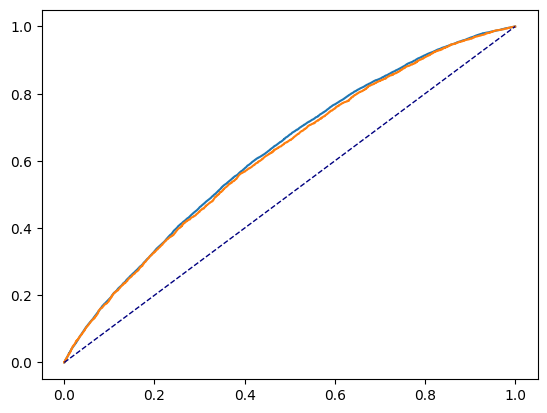

In [9]:
# get roc curve for the model on both train and test
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(train_woe['OneMonth_target'], model.predict_proba(train_woe[base_features])[:,1])
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(test_woe['OneMonth_target'], model.predict_proba(test_woe[base_features])[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.show()

In [11]:
# get f1 score for the model on both train and test
from sklearn.metrics import f1_score
print('train f1:', f1_score(train_woe['OneMonth_target'], model.predict(train_woe[base_features])))
print('test f1:', f1_score(test_woe['OneMonth_target'], model.predict(test_woe[base_features])))

train f1: 0.0021160576218767803
test f1: 0.002809646452821353


In [19]:
base_features = ["state_woe", "months_paying_woe", "age_drv_woe", "base_price_woe", "appfeatures_woe", 
                 'countallvehiclesgasaddedpast6mths_woe', 'curraddrmedianincome_woe']
dict = {}
best_rate = 0
best_col = ''
for col in base_features:
    base_features.remove(col)
    model = linear_model.LogisticRegression()
    model.fit(train_woe[base_features], train_woe['OneMonth_target'])
    # return probability of each row in test
    prob = model.predict_proba(valid_woe[base_features])
    # return probability of 1
    prob = [p[1] for p in prob]
    # sort prob in order
    valid_woe['prob'] = prob
    valid_woe.sort_values(by='prob', ascending=True, inplace=True)
    # group rows into 10 groups with same number of rows
    valid_woe['group'] = pd.qcut(valid_woe['prob'], 10, labels=False)
    valid_woe['OneMonth_target_Cnt'] = valid_woe['OneMonth_target']

    # group by group, calculate the sum of OneMonth_target and count of OneMonth_target
    test_group = valid_woe.groupby('group').agg({'OneMonth_target': 'sum', 'OneMonth_target_Cnt': 'count'}).reset_index()
    # calculate rate of OneMonth_target by OneMonth_target /  pred
    test_group['rate'] = test_group['OneMonth_target'] / test_group['OneMonth_target_Cnt']
    # get rate of OneMonth_target from group as 0
    rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
    rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
    rate_9 / rate_0
    print(col, rate_9 / rate_0)
    dict[col] = rate_9 / rate_0
    if rate_9 / rate_0 > best_rate:
        best_rate = rate_9 / rate_0
        best_col = col
    # add the column back to first position
    base_features.insert(0, col)

state_woe 3.9556385375618253
months_paying_woe 2.4978584074729797
age_drv_woe 3.5104633536810197
base_price_woe 3.73567335243553
appfeatures_woe 3.333636666253031
countallvehiclesgasaddedpast6mths_woe 3.9986004230957817
curraddrmedianincome_woe 3.9655643231592594


In [35]:
# find any column with state in it
for col in train.columns:
    if 'age' in col:
        print(col)

primary_package_id
countallvehiclesvolkswagen
countactivevehiclesvolkswagen
countallvehiclespurchasednewvolkswagen
countactivevehiclespurchasednewvolkswagen
countallvehiclespurchasedusedvolkswagen
countactivevehiclespurchasedusedvolkswagen
countdisposedvehiclesvolkswagen
countdisposedvehiclespurchasednewvolkswagen
countdisposedvehiclespurchasedusedvolkswagen
pctactivevehiclesvolkswagenderived
special_usage_flag
exact_age_p1
combined_age_indicator
age_in_years_drv_numeric
home_land_square_footage
home_land_front_footage
home_land_depth_footage
home_building_square_footage
home_base_square_footage
oo_home_mortgage_amt
mortgage_term_in_months
refi_mortgage_amt
mortgage_amount_in_thousands2
dl_cppm_mortgage_term
cfi_mortgage_refinance_score
inq_mortgage
v1_prospectage
v1_hhteenagermmbrcnt
v1_hhmiddleagemmbrcnt
v1_raateenagemmbrcnt
v1_raamiddleagemmbrcnt
source_usage
age_drv
mortgage_age
age_16_24_in_hh
coveragetier
mortgage_protection_model
mortgage_protection_decile
combined_age
combined_

In [48]:
import numpy as np
from scipy import stats
import pandas as pd

# p value
# remove rows wuth missing values
valid_woe.dropna(inplace=True)
params = np.append(model.intercept_, model.coef_)
predictions = model.predict(valid_woe[base_features])
newX = np.append(np.ones((len(valid_woe), 1)), valid_woe[base_features], axis=1)
MSE = (sum((valid_woe['OneMonth_target'] - predictions) ** 2)) / (len(newX) - len(newX[0]))

# Compute the dot product
matrix = np.dot(newX.T, newX)

# Check if the matrix is singular
if np.linalg.det(matrix) != 0:
    inv_matrix = np.linalg.inv(matrix)
else:
    inv_matrix = np.linalg.pinv(matrix)

var_b = MSE * inv_matrix.diagonal()
sd_b = np.sqrt(var_b)
ts_b = params / sd_b
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

# summary
summary = pd.DataFrame()
summary["features"] = ['intercept'] + base_features
summary["coefficients"] = params
summary["p_values"] = p_values
summary

,features,coefficients,p_values
0,intercept,-1.170349,0.000000e+00
1,statecode_woe,0.963276,0.000000e+00
2,months_paying_woe,0.895269,0.000000e+00
3,combined_age_woe,0.816164,0.000000e+00
4,base_price_woe,0.738878,0.000000e+00
5,appfeatures_woe,1.303823,0.000000e+00
6,vehicle_age_woe,0.186623,1.116884e-13
